In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
import gensim
from Bio import SeqIO
import numpy as np
from numpy import linalg as LA
from collections import UserDict
from sklearn import preprocessing
from functools import reduce
from operator import add
from sklearn.linear_model import LogisticRegression
import pandas as pd
from pepdata import amino_acid
from sklearn.manifold import TSNE

In [2]:
def make_ngrams(seq, n, shift=True):
    res = []
    if shift:
        for i in range(n):
            res.append(list(map(''.join, (zip(*[iter(seq[i:])]*n)))))
    else:
        res.append(list(map(''.join, (zip(*[iter(seq)]*n)))))
    
    return res

In [340]:
def process_fasta(fname, n, shift=True):
    res = []
    fd = SeqIO.parse(fname, "fasta")
    for r in fd:
        res += make_ngrams(r, n, shift)
    
    return res

In [341]:
a = process_fasta("./uniprot_sprot.fasta", 3, True)

In [342]:
len(a)

1664580

In [343]:
#model = gensim.models.Word2Vec(a, size=100, window=20, min_count=5, workers=16)

In [344]:
mod = gensim.models.Word2Vec(hs = 0, negative = 20, workers = 32, iter=1000, window=3, sg=1)

In [ ]:
mod.build_vocab(a)

In [ ]:
mod.train(a, total_examples=mod.corpus_count, epochs=mod.iter)

In [ ]:
mod.save("model_neg20_w3_1000it_hs0_sg1")

In [ ]:
len(mod.wv.vocab)

In [ ]:
mod.wv.save_word2vec_format("model_neg20_w3_1000it_hs0_sg1_w2v", fvocab="vocab")

In [78]:
def read_embeddings(filename):
    res = UserDict()
    f = open(filename)
    v_size, e_size = [int(i.strip()) for i in f.readline().split()]
    for l in f.readlines():
        l = l.split()
        w = l[0]
        v = np.array([float(i) for i in l[1:]])
        res[w] = v
    res.wsize = len(w)
    return res

In [150]:
emb = read_embeddings("model_neg20_w20_100it_hs0_sg1_w2v")

In [220]:
def make_pep_vector(sequence, emb, shift=True):
    ngrams = make_ngrams(sequence, emb.wsize, shift=shift)
    ngrams = reduce(add, ngrams)
    ngrams = [ng for ng in ngrams if ng in emb.keys()]
    res = sum([emb[n] for n in ngrams])
    res = res/LA.norm(res)
    return res

In [118]:
log = LogisticRegression(penalty='l1', solver='liblinear')

In [119]:
fit = log.fit([[0.1,0.1], [0.2, 0.1], [0.1, 0.2], [0.8,0.9],[0.9,0.9], [0.8,0.8]], [0,0,0,1,1,1])

In [123]:
fit.predict([[0,0], [1,1]])

array([0, 1])

In [121]:
fit.coef_

array([[ 0.        ,  0.17273213]])

In [ ]:
df = pd.DataFrame(emb)

In [131]:
emb.__dir__

<function UserDict.__dir__>

In [132]:
from sklearn.datasets import load_iris

In [133]:
iris = load_iris()

In [135]:
X = iris.data

In [136]:
y = iris.target

In [140]:
X.shape, y.shape

((150, 4), (150,))

In [143]:
tsne = TSNE(n_components=2)

In [145]:
sne = tsne.fit_transform(X)

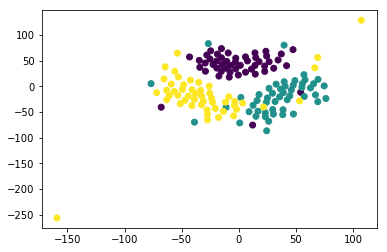

In [148]:
plt.scatter(sne[:, 0], sne[:,1], c= y)

In [151]:
emb

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [155]:
ng, vec = zip(*[(x, y) for x, y in emb.items()])

In [169]:
def prop(x, method = amino_acid.hydropathy):
    try:
        return method(x)
    except:
        return 0

In [170]:
hydropathy = [sum([prop(i) for i in w]) for w in ng]

In [165]:
tsne = TSNE(n_components=2)

In [166]:
wsne = tsne.fit_transform(vec)

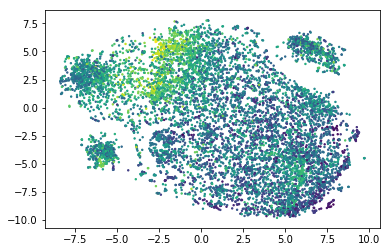

In [176]:
plt.scatter(wsne[:, 0], wsne[:,1], c= hydropathy, s=2)

In [171]:
volume = [sum([prop(i, amino_acid.volume) for i in w]) for w in ng]

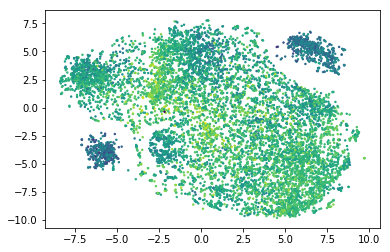

In [175]:
plt.scatter(wsne[:, 0], wsne[:,1], c= volume, s=2)

In [173]:
pol = [sum([prop(i, amino_acid.polarity) for i in w]) for w in ng]

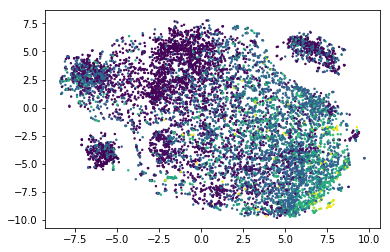

In [177]:
plt.scatter(wsne[:, 0], wsne[:,1], c= pol, s=2)

## FGNUPS ##

In [203]:
fgnups = SeqIO.parse("test/fgnupscat.fasta", "fasta")
fgnups = list(fgnups)

In [207]:
sp = list(SeqIO.parse("./uniprot_sprot.fasta", "fasta"))

In [210]:
from random import choice

In [211]:
sp = [choice(sp) for _ in range(len(fgnups))]

In [224]:
fgnups_vecs = list(map(lambda s: make_pep_vector(s, emb), fgnups))

In [225]:
sp_vecs = list(map(lambda s: make_pep_vector(s, emb), sp))

In [226]:
colv = [0]*len(fgnups_vecs)+[1]*len(sp_vecs)

In [227]:
allvecs = fgnups_vecs+sp_vecs

In [228]:
asne = TSNE(n_components=2)

In [229]:
asne = asne.fit_transform(allvecs)

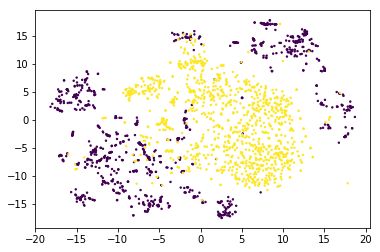

In [232]:
plt.scatter(asne[:, 0], asne[:,1], c= colv, s=2)

In [234]:
from sklearn import model_selection

In [235]:
model_selection.train_test_split()

sklearn.model_selection._split.BaseCrossValidator

In [236]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(allvecs, colv)

In [237]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1638, 546, 1638, 546)

In [238]:
from sklearn import svm

In [248]:
m = svm.LinearSVC()

In [255]:
m.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [259]:
m.score(X_test, y_test)

0.95970695970695974

In [251]:
scores = model_selection.cross_val_score(m, allvecs, colv, cv=5)

In [253]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.97 (+/- 0.01)


In [254]:
from sklearn.metrics import precision_recall_fscore_support

In [258]:
precision_recall_fscore_support(y_test, m.predict(X_test),average="binary")

(0.96934865900383138, 0.94756554307116103, 0.95833333333333315, None)

In [260]:
m.score(X_test, y_test)

0.95970695970695974

## AMP ##

In [274]:
from random import choice

http://aps.unmc.edu/AP/

In [261]:
amps = SeqIO.parse("test/APD_AMPs_fasta_DongChuan.fa", "fasta")
amps = list(amps)

In [271]:
sp = SeqIO.parse("./uniprot_sprot.fasta", "fasta")

In [281]:
ampcat = reduce(add, amps)
ampneg = []
for amp in amps:
    ampneg.append("".join([choice(ampcat) for _ in range(len(amp))]))

In [268]:
maxl_amp = max(map(len, amps))

In [290]:
ampneg = [s.strip() for s in open("test/1740_NCBI_random_peptides.txt").readlines()]

In [292]:
amp_vecs = list(map(lambda s: make_pep_vector(s, emb), amps))
ampneg_vecs = list(map(lambda s: make_pep_vector(s, emb), ampneg))
amp_all_vec = amp_vecs+ampneg_vecs
colv = [0]*len(amp_vecs)+[1]*len(ampneg_vecs)

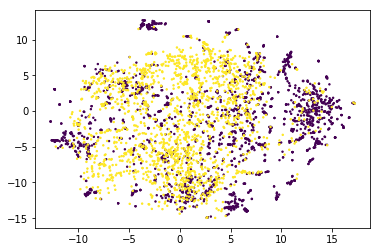

In [293]:
ampsne = TSNE(n_components=2)
ampsne = ampsne.fit_transform(amp_all_vec)
plt.scatter(ampsne[:, 0], ampsne[:,1], c= colv, s=2)

In [298]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(amp_all_vec, colv)

In [318]:

mp = svm.LinearSVC(penalty="l1", dual=False)
mp.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
     verbose=0)

In [319]:
mp.score(X_test, y_test)

0.83823529411764708

In [320]:
mp.coef_

array([[ 0.6346146 , -0.56496527,  0.        , -4.50093938,  0.        ,
         0.69646558, -1.51846166,  0.        , -0.22718418, -0.6168795 ,
         0.        , -1.72711998, -1.76293825,  1.993322  ,  0.        ,
         0.90449644,  2.0153184 ,  0.        , -1.59529764, -4.20132918,
        -1.44463894,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  2.52043505,  0.        ,  0.        ,  0.73593161,
        -3.26898822,  1.68501618,  0.        ,  2.27646421,  1.89272858,
         0.        , -1.35350551, -2.05237163,  0.        ,  0.        ,
         3.09020536,  0.        ,  0.        ,  1.00080947,  0.        ,
         0.        ,  1.28361157, -1.99848738,  0.        ,  0.        ,
         0.        , -1.4298078 ,  0.        ,  0.7855697 , -3.76277001,
        -4.4245242 , -0.23188697, -0.54472237,  0.        ,  5.86262612,
         2.07257428, -1.7274737 , -0.55931132,  0.        ,  0.10115225,
        -2.2574348 ,  5.69290548,  0.        ,  0.6

In [321]:
precision_recall_fscore_support(y_test, mp.predict(X_test),average="binary")

(0.85158150851581504, 0.77092511013215859, 0.80924855491329473, None)

In [311]:
def pepcls(peps1, peps2, emb, sne=True):
    v1 = list(map(lambda s: make_pep_vector(s, emb), peps1))
    v2 = list(map(lambda s: make_pep_vector(s, emb), peps2))
    all_vec = v1+v2
    truey = [0]*len(v1)+[1]*len(v2)
    if sne:
        tsne = TSNE(n_components=2)
        tsne = tsne.fit_transform(all_vec)
        plt.scatter(tsne[:, 0], tsne[:,1], c= truey, s=2)
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(all_vec, truey)
    mod = svm.LinearSVC()
    mod.fit(X_train, y_train)
    print("Score: ", mod.score(X_test, y_test))
    print("P_R_F: ", precision_recall_fscore_support(y_test, mod.predict(X_test),average="binary"))

Score:  0.85
P_R_F:  (0.85051546391752575, 0.77647058823529413, 0.81180811808118081, None)


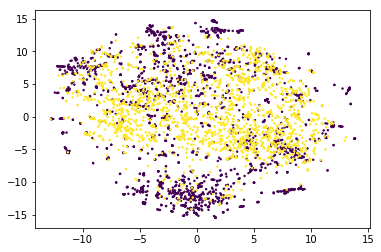

In [313]:
pepcls(amps, ampneg, emb)